# Encoding Categorical Variables. The Rainbow Method !!!DRAFT
> 'When the nature gives you a rainbow, take it.'

- author: Anna Arakelyan, Dmytro Karabash
- categories: [python, data science, classification, encoding]
- image: /audio2images/
- permalink: /rainbow/
- hide: true

## Introduction

"I have 2000 features and I need to get to 50 features and keep model as good or better" was how this all started.  This is familiar to anyone in institutional data science where you need to carefully vet every model and look at each feature to make sure it is fine from the standpoint of regulation.  What is valuable about this story is that it is based on a real production model that was developed by Anna Arakelyan at Mass Mutual and a method suggested by Dmytro Karabash.  We will get to detailed results at the end but let us give us some preview:

In [1]:
#hide_input

import pandas as pd 
pd.set_option('display.max_columns', None)

# Add 'rainbow_research.csv' and 'rainbow_research_feature_selection.csv' in the _notebooks folder
# Don't push data to repo - they must be ignored in .gitignore
results = pd.read_csv('../data/rainbow_research.csv').rename(columns={'feature_selection_parameter':'Num_features',"transform_parameter": "method"})

feature_selection = pd.read_csv('../data/rainbow_research_feature_selection.csv').rename(columns={'feature_selection_parameter':'Num_features',"transform_parameter": "method"})
metrics=['accuracy', 'kappa', 'macro avg_f1-score', 'weighted avg_f1-score', 'macro avg_roc_auc', 'weighted avg_roc_auc']
tmp = feature_selection.groupby(['Num_features', 'method'])[metrics].mean().round(4).reset_index()

tmp['Num_features']=tmp['Num_features'].str.replace('top_',"").astype(int)
table1 = tmp.set_index(['Num_features', 'method']).sort_index()

table1=table1.rename(columns={'macro avg_f1-score': 'macro-f1',
                       'weighted avg_f1-score':'weighted-f1',
                       'macro avg_roc_auc':'macro-auc',
                       'weighted avg_roc_auc' : 'weighted-auc'
                      })
table1[['macro-f1','accuracy','kappa','macro-auc']].round(2)

macro-f1  accuracy  kappa  macro-auc
Num_features method                                       
10           one_hot      0.27      0.39   0.15       0.68
             rainbow      0.33      0.41   0.19       0.70
50           one_hot      0.33      0.42   0.20       0.70
             rainbow      0.34      0.42   0.21       0.71
100          one_hot      0.33      0.42   0.20       0.71
             rainbow      0.35      0.42   0.21       0.71

The rainbow method outperforms for any number of features as well as giving better result for 50 features than one-hot encoding for 100 . Please also note that drop decrease in kappa if you use one-hot is 5 times that of rainbow method ( 3 times for kappa and micro-auc, 2 times for accuracy).

(Note*: Both models actually keep improving if you remove features smart to 100).
!!!would be nice to add such a chart to show this.

## Background

Data encoding is the crucial part of any data science pipeline. No matter what is the final goal or which machine learning algorithm will be used - there is no avoiding of data massaging, cleaning, and encoding. Given that real data sets are rarely as clean and suited for analysis as toy data sets from data science classes, there is a number of decisions you have to make to encode and engineer features in the most appropriate and efficient way.
While the encoding of quantitative and binary columns is generally straightforward, the encoding of categorical variables deserves a deeper look. 
<br><br>
One of the most popular encoding methods for categorical variables has been the One-Hot procedure. It generates an indicator variable for every category and, thus, creates a set of K new features, where K is the number of categories.
One significant implication of this method is the dimensionality increase. Depending on the magnitude of K, it can have various undesirable technical consequences: substantial raise of computational complexity, loss of degrees of freedom (N-K, where N is the number of samples), multicollinearity, and, ultimately, an overfitted model. Non-technical consequences include unnecessary complication of the model that should be communicated to final users and that contradict the law of parsimony, also known as Occam's razor.

## Method

We call it rainbow from a very simple analogy, if you have categorical feature with names "red", "orange", "yellow", "green", "blue", "indigo" and "violet", in other words colors of the rainbow, instead of doing 1-hot encoding or (binary 1-hot encoding), you can simply use encoding red -> 0, orange ->1,..., violet -> 6.  This would replace seven 1-hot features with one rainbow.  The method also suggests that you can actually use two rainbows, one natural as described before and the other say by hue or warmth.  You can even use three rainbows but I wouldn't use more than $log_2(N)$ if you have N categories.

Why is rainbow better than any other choice? It is first thing that comes to mind and you do not have to think about it.  In many cases it is not really that necessary which rainbow you choose (and by this we mean ordering of these colors), most of the would be better than using 1-hot, there are just some natural ones, which are more likely to be better than other (and easier to remember). 

"When a nature gives you a rainbow, take it..."


!!!Remove:
Instead of One-Hot, we propose an alternative way to encode categorical variables. Imagine that instead of K features you would make only one. The trick is to treat categorical variables as quantitative and find a certain way to order categories. 

>Important note here: this method is highly efficient in conjunction with the models that rely on variables as ranks rather than exact values. For example, decision trees, random forest, gradient boosting - these algorithms will output the same result if the variable *Number of Children* is coded as [1, 2, 3, 4, 5, ...] or as [-100, -85, 0, 10, 44, ...] as long as the categories have a correct order, and we use correct interpretation of non-meaningful values.
The application of our method for other algorithms such as Linear Regression, Logistic Regression is out of scope of this article. We expect that such way of feature engineering would be still beneficial, but this is a subject of a different investigation.

## Examples

The application of our method depends highly on the level of measurement. While **quantitative** variables have a *ratio* scale, i.e. they have a meaningful 0, ordered values, and equal distances between values; **categorical** variables usually have either *interval*, or *ordinal*, or *nominal* scales.
Let us illustrate our method for each of these types of categorical variables.

**Interval** variables have ordered values, equal distances between values, but the value itself is not necessarily meaningful, for example, 0 does not always mean a complete absence of a quality. The common examples of interval variables are Likert scales:
<br>
***
"How likely is the person to buy a smartphone mobile phone?" 
<br>
1 = Very Unlikely <br>
2 = Somewhat Unlikely<br>
3 = Neither Likely, Nor Unlikely<br>
4 = Somewhat Likely<br>
5 = Very Likely
***

In a straightforward way, if we simply use the raw values 1 through 5, that will save us dimensionality without losing a single bit of information. Indeed, the algorithm such as *xgboost* will make splits on this scale to introduce a new node any number of times it finds the best, instead of being forced to use the splits predetermined by One-Hot. With a large K, the algorithm would be forced into using big number of predermined splits which might be simply an overfit.

**Ordinal** variables have ordered values that are meaningless, and the distances between values are also not equal or not even explainable. An example: <br>
***
"What is the highest level of Education completed by the person?"
<br>
1 = No High School<br>
2 = High School <br>
3 = Associate Degree <br>
4 = Bachelor's Degree <br>
5 = Master's Degree <br>
6 = Doctoral Degree <br>
***

Similar to interval variables, ordinal numeric codes can be used in the model without introducing any challenges, as long as the order is correct. In some cases, a variable is intrinsically ordinal, but the given numeric codes are not in the correct order - in these situations we could simply reorder categories and then use this updated variable as a quantitative feature.

Interval and ordinal categorical variables are probably not raising concerns as they are clearly perfect alternative to One-Hot for tree-based algorithms. The more complicated and non-obvious question is how to treat nominal variables.

**Nominal** variables have no obvious order between categories, and are almost always encoded with One-Hot method. A nice example of a nominal variable is
***
"Color" <br>
(For instance, which color marker a person have chosen in some psychological state)
<br>
A = Red <br>
B = Blue <br>
C = Green <br>
D = Yellow <br>
***

From the first glance it seems like we can't convert this variable to a quantitative scale. This is where our proposed method will help! We suggest **finding a rainbow**.

These seemingly unordered categories acquire a perfect order if we find a certain scale where each category fits into a unique place. With the color, such scale could be the Hue! In other words, the wavelength of the light is the factor the helps us order the colors into a perfect scale - a rainbow! So, following that logic, we would engineer a new feature:
***
1 = Blue <br>
2 = Green<br>
3 = Yellow<br>
4 = Red<br>
***

The Hue is not the only way to order the colors. We could think of a few different scales, such as brightness, saturation, color temperature, lightness, etc. We invite you to experiment with a few different "rainbows" that might capture different nuances of the categorical quality. <br>Note that by using a rainbow rather than One-Hot we are not losing any of the signal, because, even if the categories are wildly different and each one introduces a substantial gain to the model, the algorithm such as *xgboost* would capture that by making all the needed splits when introducing new tree nodes.

Lets us show a few other examples of creating rainbows.

***
"Marital Status" <br>
A = Married <br>
B = Single <br>
C = Inferred Married <br>
D = Inferred Single <br>
***

If we think about Single and Married as the two ends of the spectrum, then Inferred Single could be between the two, closer to Single while Inferred Married between the two closer to Married. That would make sense because being Inferred holds some degree of uncertainty. Thus, the following order would be reasonable:
***
1 = Single <br>
2 = Inferred Single <br>
3 = Inferred Married <br>
4 = Married
***

In case there are any missing values here, the Unknown category fits exactly in the middle between Single and Married as there is no reason to prefer one end over the other. So the modified scale could look like this:
***
1 = Single <br>
2 = Inferred Single <br>
3 = Unknown <br>
3 = Inferred Married <br>
4 = Married
***

Consider another variable:
***
"Occupation" <br>
1 = Professional/Technical<br>
2 = Administration/Managerial<br>
3 = Sales/Service<br>
4 = Clerical/White Collar<br>
5 = Craftsman/Blue Collar<br>
6 = Student<br>
7 = Homemaker<br>
8 = Retired<br>
9 = Farmer<br>
A = Military<br>
B = Religious<br>
C = Self Employed<br>
D = Other<br>

Finding a rainbow here might be harder, but here are a few ways to do it - we could order occupations by average annual salary, by its prevalence in the geographic area of interest, or by !!!add smth?!!!. That might involve calling a Census API or some other data source, and might be complicated by the fact that these values are not static, but they are still viable solutions.

## What if there is no natural rainbow?

In some situations though we cannot find a logical order for the rainbow because the variable itself is not interpretable. An example could be a black box column made by a third party:
***
"Financial Cluster" <br>
1 = Market Watchers <br>
2 = Conservative Wealth <br>
3 = Specific Savers <br>
4 = Tried and True <br>
5 = Trendy Inclinations <br>
6 = Current Consumers <br>
7 = Rural Trust <br>
8 = City Spotlight <br>
9 = Career Conscious <br>
10 = Digital Financiers <br>
11 = Financial Futures <br>
12 = Stable Influentials <br>
13 = Conservatively Rural
***

In this case we might not have a clear idea how to order categories due to lack of knowledge of what each category entails. What to do with such variables?

We recommend creating an artificial rainbow by looking at how each category is related to the target variable. In case of a binary classification problem we have a binary target variable, and we could construct a rainbow at least two different ways. 

First way is to place categories in the order of correlation with target variable. So the category with the highest value of correlation with the dependent variable would acquire numeric code 1, and the category with the lowest correlation would acquire numeric code 13. So our rainbow in this case would mean the relationship between the cluster and the target variable.

Second way is similar to the first one, but instead of correlation, we could look at the percent of target variable taking value of 1 (positive) given each of the categories. Suppose, among Market Watchers percent of positive targets is 0.67, while for Conservative Wealth it is 0.45. In that case, Market Watchers will be ordered higher than Conservative Wealth (or lower, if the target percent scale is ascending). In other words, this rainbow would reflect the prevalence of positive target inside each category. 

In case of multiclass classification, we could create rainbows for each class to represent relationship between categories and each class separately. In the case of regression and continuous target, we could rely on the correlation method mostly.

We briefly described the Rainbow method, and below we provide theoretical justification for it and then an empirical application that illustrates its superiority over One-Hot.

## Application to a Real Data Science Problem

We will illustrate the effectiveness of the rainbow encoding method using the real data science project developed in the Customer Journey domain of Data Science group at MassMutual - a life insurance company with a team of over 200 top-notch data scientists, engineers, and technologists.

### Business Use Case

In a nutshell, the data task is a multiclass classification problem that aims to predict one of the five Mindset Segments for each of the prospective customers. 

| Segment | Description |
| :- | :- |
| Self-Assured |Confident, in control, and middle-aged, often with families|
| Juggler | (>= 35 years old) Younger families, less confident in their finances|
| Starter |(< 35 years old) Youngest segment, with lower levels of financial confidence due to lack of experience|
| Day to Day | Older, worried, and pessimistic about their finances |
| Well-Established | In control, and highly satisfied with financial situation |


The segmentation framework represents five classes that reflect a person's age, financial stability, and attitude towards financial decisions. The predicted segments are then used by marketers in different types of campaigns for targeting and customization. For example, Self-Assured customers would value more independence and autonomy in making decision of buying a life insurance policy whereas Day to Day customers would value having a guidance and a long and thorough explanations of different financial products by a dedicated advisor.

The true segment labels come from MassMutual vendors that ran the mindset survey in 2017, 2018, and 2020. The total size of data is 17.5K rows. The main database we use for this problem is provided by Acxiom and covers about 300 columns representing rich set of demographic characteristics, composition of the household, income and net worth, financial behavior, and digital savvyness. 

In [4]:
#hide

size_of_data = int((results['n_train'] + results['n_test'])[0])
size_of_data

17493

Using Acxiom data and the Mindset Segmentation prediction task, we will compare the conventional One-Hot encoding with the Rainbow method. For a task of 5-class classification we will demonstrate the following metrics - accuracy, Cohen's kappa, and a few other standard metrics

Cohen's Kappa is one the best metrics for an unbalanced multiclass classification problem. Accuracy is used for a simple interpretation purposes.

### All Categorical Variables

First of all, we took all existing categorical variables - interval, ordinal, and nominal, and excluded any other variables - quantitative and binary. We would like to compare the model performance using the two types of encoding for the same set of catogorical factors. <br><br>
We then applied a target stratified 4-fold Cross Validation split. All the data processing from this point on is done inside the cross validation loop, i.e. the creation of One-Hot features and Rainbow features is learned from each fold train set and applied to each fold validation set. <br> <br>
The total set of 111 variables was transformed into **201** Rainbow features and, alternatively, into **2260** One-Hot features (with very slight deviations in N in 4 different folds).

| Type of variable | N raw | N Rainbow encoded | N One-Hot encoded |
| :-:| :-: | :-: | :-:|
| Interval |64| 64 | 1670 |
| Ordinal | 14 | 14 | 178 |
| Nominal |33| 123 | 412 |
| Total | 111 | **201** | **2260** |

### About Nominal Variables

One can notice that number of raw and Rainbow encoded features is the same (64 and 14), while 33 raw nominal features turned into 123 Rainbow features. That is because interval and ordinal features have a straightforward rainbow tranformation whereas there were two kinds of nominal variables. Out of 33 nominal variables, for 23 we found a natural rainbow, while for 10 variables we applied correlation ordering and target percent ordering. Since we deal with 5 classes, we made 10 new features for each of these variables.
For example, given the name of feature "Financial_Cluster" and 5 segment names, we made features
- Financial_Cluster_Self-Assured_correlation_rank
- Financial_Cluster_Juggler_correlation_rank
- Financial_Cluster_Starter_correlation_rank
- Financial_Cluster_Day to Day_correlation_rank
- Financial_Cluster_Well-Establishes_correlation_rank
<br><br> and <Br><br>
- Financial_Cluster_Self-Assured_target_percent
- Financial_Cluster_Juggler_target_percent
- Financial_Cluster_Starter_target_percent
- Financial_Cluster_Day to Day_target_percent
- Financial_Cluster_Well-Establishes_target_percent
 <br><br>
In this way, 33 raw nominal variables turned into 123 Rainbows.

It is important to note that the search for natural or non-natural Rainbows is highly project and context specific, and is more of an art than a craft. For instance, for a binary classification problem, there probably would have been only one or two Rainbows for each categorical feature given a single target class.

# Results and conclusions

In [64]:
## THIS CODE WILL BE HIDDEN, OUTPUT WILL BE SHOWN - probably, as a manual mardown table
t=results
t[t['feature_group']=='all'].groupby(['method'])[['accuracy', 'kappa']].mean().round(3)

,accuracy,kappa
method,,
one_hot,0.407,0.174
rainbow,0.420,0.201


Clearly, the average metrics across all models are notably higher for Rainbow encoding. The following plots show dynamic of metrics depending on every hyperparameter. These plots also clearly demonstrate the superiority of Rainbow method for every hyperparameter and every metric.

["'!pick' is not recognized as an internal or external command,",
 'operable program or batch file.']

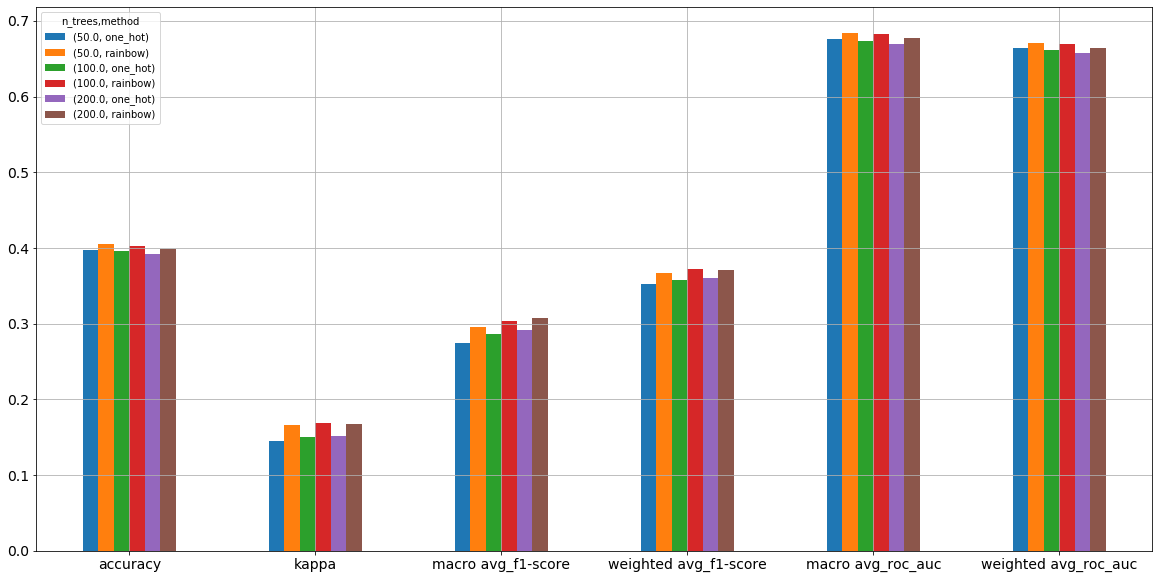

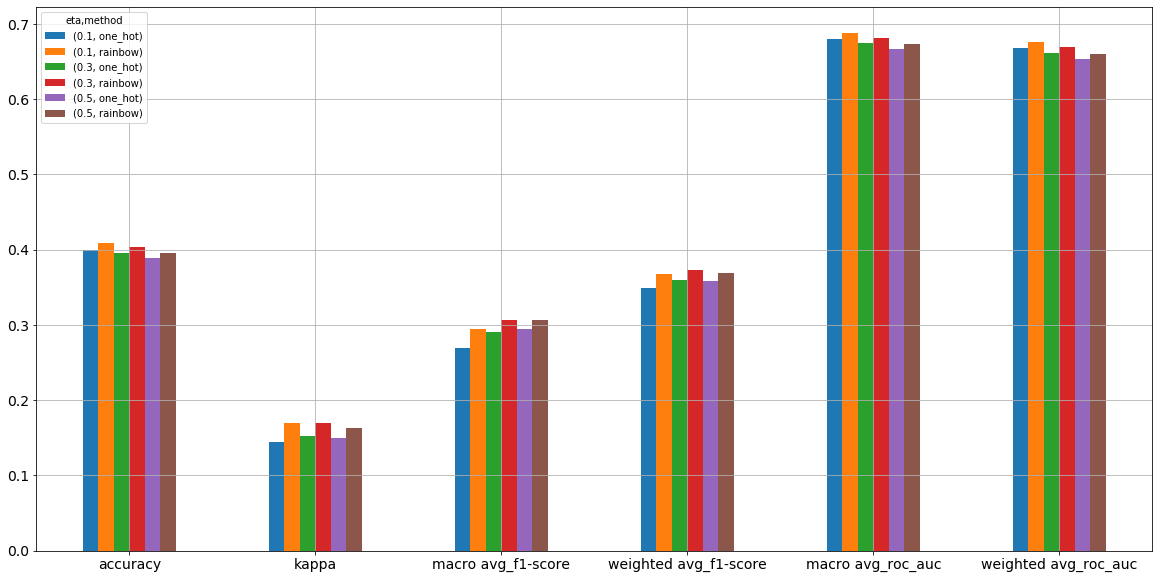

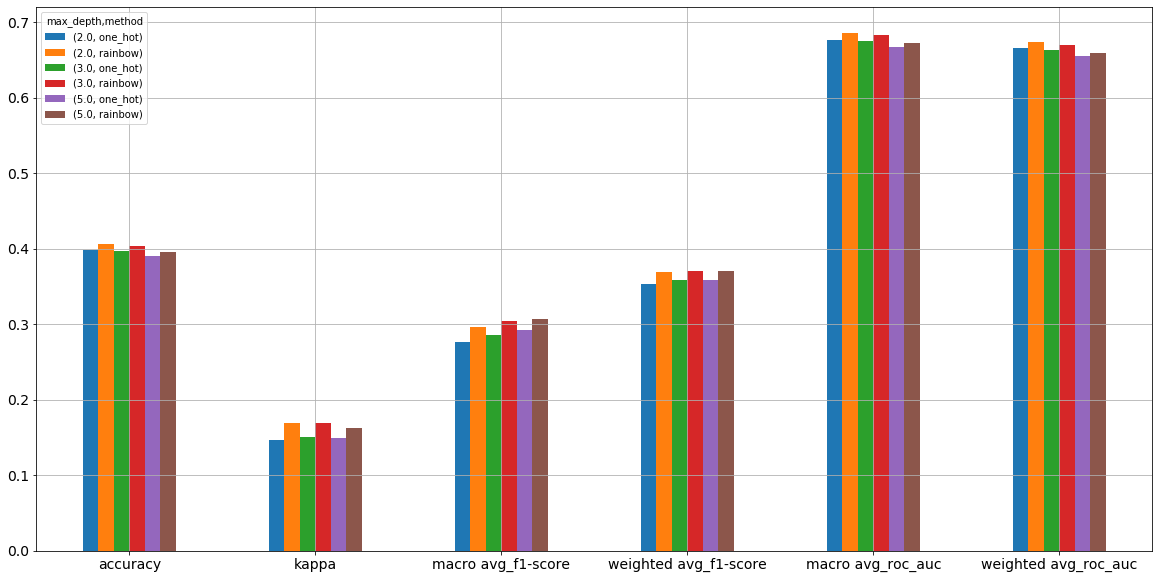

In [61]:
#hide_input

p0=t.groupby(['n_trees','method'])[metrics].mean().round(3).T#.plot(kind='bar',figsize=(20,10),rot=0,fontsize=14,grid=True)
p1=t.groupby(['eta','method'])[metrics].mean().round(3).T#.plot(kind='bar',figsize=(20,10),rot=0,fontsize=14,grid=True)
p2=t.groupby(['max_depth','method'])[metrics].mean().round(3).T#.plot(kind='bar',figsize=(20,10),rot=0,fontsize=14,grid=True)


p0.plot(kind='bar',figsize=(20,10),rot=0,fontsize=14,grid=True)
p1.plot(kind='bar',figsize=(20,10),rot=0,fontsize=14,grid=True)
p2.plot(kind='bar',figsize=(20,10),rot=0,fontsize=14,grid=True)
!!!pick one

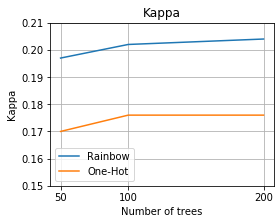

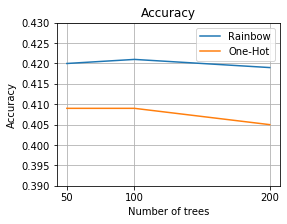

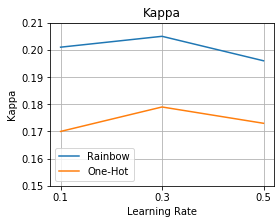

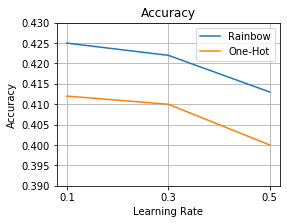

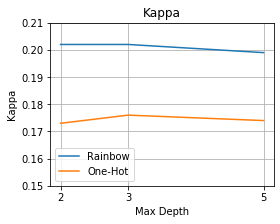

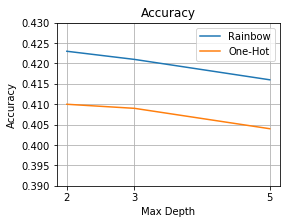

In [11]:
#hide_input 

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

def make_plot(t, feature_group, hyperparameter, hyperparameter_name, metric, ylimit_bottom, ylimit_top, xticks_list):
    k1 = pd.DataFrame(t[t['feature_group']==feature_group][t['method']=='rainbow'].groupby(
        hyperparameter)[metric].mean().round(3))
    k2 = pd.DataFrame(t[t['feature_group']==feature_group][t['method']=='one_hot'].groupby(
        hyperparameter)[metric].mean().round(3))
    fig, ax = plt.subplots(figsize=(4,3))
    plt.plot(k1.index, k1[metric], label = 'Rainbow')
    plt.plot(k2.index, k2[metric], label = 'One-Hot')
    plt.ylim(ylimit_bottom, ylimit_top)
    ax.set_xticks(xticks_list)
    plt.grid()
    plt.legend()
    plt.xlabel(hyperparameter_name)
    plt.ylabel(metric.capitalize())
    plt.title(metric.capitalize())
    plt.show()

t=results
make_plot(t, 'all', 'n_trees', 'Number of trees', 'kappa', 0.15, 0.21, [50, 100 ,200])
make_plot(t, 'all', 'n_trees', 'Number of trees', 'accuracy', 0.39, 0.43, [50, 100 ,200])
make_plot(t, 'all', 'eta', 'Learning Rate', 'kappa', 0.15, 0.21, [0.1, 0.3 ,0.5])
make_plot(t, 'all', 'eta', 'Learning Rate', 'accuracy', 0.39, 0.43, [0.1, 0.3 ,0.5])
make_plot(t, 'all', 'max_depth', 'Max Depth', 'kappa', 0.15, 0.21, [2, 3 ,5])
make_plot(t, 'all', 'max_depth', 'Max Depth', 'accuracy', 0.39, 0.43, [2, 3, 5])

!!!This should probably be a 2*3 plots matrix. <br> Also, other metrics? <br> Also, combinations of hyperparameters? Like max_depth =2, num_trees = 50, eta = 0.5 - the simplest model compare rainbow vs one_hot? <br> Any graphic representaiton of that? <br>
Any other ideas?
<br>
Maybe beautifying charts in some way? Other colors?!!!

Next, let's compare the runtime for each method. Average model running time is about 9 times faster for Rainbow method than for One-Hot. So, in addition to a substantial increase in model performance metrics, Rainbow method can save data scientists huge amount of time.

In [7]:
## THIS CODE WILL BE HIDDEN, OUTPUT WILL BE SHOWN - probably, as a manual mardown table
t=results
pd.DataFrame(t[t['feature_group']=='all'].groupby(['method'])['total_time'].mean().round(3))

,total_time
method,
one_hot,66.074
rainbow,7.444


### Interval, Ordinal, and Nominal

Below are the results of the models that applied two types of encoding to interval, ordinal, and nominal features separately.

In [9]:
## THIS CODE WILL BE HIDDEN, OUTPUT WILL BE SHOWN - probably, as a manual mardown table
t[t['feature_group']!='all'].groupby(['feature_group','method'])[['accuracy', 'kappa']].mean().round(4)

accuracy   kappa
feature_group method                   
interval      one_hot    0.4003  0.1563
              rainbow    0.4149  0.1894
nominal       one_hot    0.3938  0.1542
              rainbow    0.3915  0.1544
ordinal       one_hot    0.3784  0.1113
              rainbow    0.3827  0.1247

As expected, interval and ordinal features gain the most from Rainbow encoding, while nominal variables - less so.

### Feature Selection

Finally, to make a comparison more fair in terms of dimensionality, we picked top 10, top 50, and top 100 features from each feature set - Rainbow and One-Hot. We used feature importance attribute of the XGBoost model and aggregated feature importance scores for 4 cross validation folds on the best hyperparameter set for each encoding type. Below are the results.

In [ ]:
#hide_input

table1

*weighted in the table above is class-weighted.

Kappa is significantly higher for the Rainbow method, especially with the lower number of selected features. As mentioned before rainbow with 50 features is better than one-hot with 100 features, we just see this that is true in all the regularly used metrics.  Note the drop for macro-f1 score drop from 50 to 10 features in one-hot versus rainbow.

In [ ]:
#hide

#import numpy as np
#np.log(table1[1::2]).diff().iloc[1]/np.log(table1[::2]).diff().iloc[1]

## Conclusion

As shown above, the Rainbow method is an elegant and simple way to encode categorical variables, that will significantly reduce the data dimensionality without losing any part of valuable signal, that will likely cause substantial improvements in model performance metrics (or, at the very least, will not cause any reductions in metrics), and that will save great amount of time for modelers.

Finally, we should note that this article just opens the conversation about the Rainbow method, and by no means exhausts the topic. In the potential future investigations, we could explore some other aspects. To name a few: binary and continuous target variables; comparison with other dimensionality reduction methods, such as PCA; how missing values fit the Rainbow framework; is there any limit and implications of combining seemingly unrelated features into a single Rainbow. We hope to open the gate for further questions and feedback on this method.

# Conditional Mathematical Foundation

## Framework

Aside from reducing number of variables which was our main goal, we would also like to understand why do rainbows produce better results.

We wouldn't completely satisfy Einstein here, but base our foundation on assumption that pruning of the trees that maximize unregularized log-loss producing supperior values.  In fact regulariation of trees, pruning of trees and various early stopping rules are all trying to achieve the same goal, which is often summarized in "avoid overfit", yet let us examine what that really means in our case by case basis. 


Imagine you have K categories for each the optimal values to be added to the nodes are 1, 2, ..., K in some order not necessarily random.  If that was the case both on-hot encoding and rainbow method would require K-1 comparisons.  We have a tie.  That would be the case where all categories should be distinquished with different values at the end-nodes, which is rarely the case. 

To make things simple lets now assume we have 4 features and the optimal values at the end nodes are 1, 1.01, 2, 2.01  Assume further that $\epsilon$ 0.01 is low enough so that the first and second pair of of categories should not be distinguished (or the nodes that distinguished should be pruned).  

That is the whole definition of "avoid overfit", the point here is that at some point signal to uncertainty ratio is to low to make a distinction and that is why xgboost has at least 7 hyperparameters that should help in not distinquishing these pairs: max_depth, gamma, min_child_weight, lambda, alpha, min_split_loss, max_leaves

Definitions of these hyperparameters can be found here https://xgboost.readthedocs.io/en/latest/parameter.html

Now to explaination how each one of these would prevent between split of first and second categories:

## Hyperparameters that help to avoid overfit.

Taking the above 1, 1.01, 2, 2.01 example let us look at how each of these 7 hyp

1. max_depth: disallows too many splits so that on each split only best splits would be chosen, so given your max_depth<K-2, you would not get to split the first and second category into different branches (those a next tree might).

2. gamma, if this one is $<0.01$, it would not split as the difference is smaller than gamma.

3. min_child_weight, if each category has less children that min_child_weight it would not split down to one category,

4. lambda: these will help not assign the tree that does split a very small weight

5. alpha: similar as lambda

6. min_split_loss: similar to gamma except it would truncate later

7. max_leaves: similar to max_depth

## How does rainbow help?

Above is just one example of how overfit might come into question, there are many other ways and for this particular reasn there are a few more parameters hat are part of xgboost parameters (rather than tree building hyperparameters described above).  These are num_boost_round and early_stopping_rounds, which both determine num of trees which will be in the final model.  To keep it simple let us stick with num_boost_round and for simplicity let us also make max_depth=1.

So in this case it makes sense to analyse the number of trees you are going to use (sing max_depth=1) it is a simple logistic model based on a number of comparisons.  In this case rainbow method would only require one which will split inbetween 2nd and 3rd category, while one-hot would require 2.

What if these were randomly permuted: then one-hot would always require 2 (it actually doesn't care about permutation), and rainbow would depend on the permutation (I will leave only integer parts): 

* for 1,1,2,2 and 2,2,1,1 it would be 1; 

* for 1,2,2,1 and 2,1,1,2 it would require 2 

* and for 1,2,1,2 and 2,1,2,1 it would require 3

So it seems in third of the cases we are better, in third same and in a third worse.  So our hope is that natural rainbows are close to 1,1,2,2 situation rather than 1,2,1,2 one.  However if we had two rainbows that would list (1,2,3,4) and (1,3,2,4) cagories we would always be able to reduce it to 1 or two comparisons.  

>The reason we suggest not to use more than $log_2 K$ rainbows is not to surpass a number of encodings in what is called binary-one-hot-encoding.  One easy way to create $log_2 K$ out of any rainbow is by rotating binary digits of your first rainbow; note rotating not permuting as if you would permute you would get $(log_2 K)!$ which is greater than K for K>8.


# One-hot versus one rainbow formula

So let us come back to a general situation of K classes and only one rainbow.  In case K classes should be split into groups in terms of tree structure, than one-hot would need $K - G_{max}$ comparisons, where $G_{max}$ is the size of the largest group and rainbow would need the number of consequitive pairs in distinct groups which can be expressed as $K-1-C$ where $C$ is the number of consequitive classes in the same group.  For a randow permutation expectation of C is the expected number of consquitive pairs multiplied by probabiliy they are in the same group: 

$$\mathbb E[C] = (N-1)  * \frac{ \sum_i G_i*(G_i-1)} {N(N-1)}=\frac{ \sum G_i*(G_i-1)} {N}=$$
where $G_i$ is the size of the $i^{th}$ group and summation is over all groups.
One can in fact show that $G_{max} \geq 1+\mathbb E[C]$:
$$ 1+\mathbb E[C] = \frac{ \sum G_i} {N} + \frac{ \sum G_i*(G_i-1)} {N} =  \frac{ \sum (G_i*(G_i-1+1))} {N} = \frac{ \sum G_i*G_i} {N} \leq \frac{ \sum G_{max} * G_i} {N} =  G_{max} \frac{ \sum G_i} {N} = G_{max} $$
so one random rainbow in this sense is worse than one-hot encodings but that is not a surpise as you have 1-feature versus K features.  

>We also see that $G_{max}-(\mathbb E [C]+1)$ is greatests when $G_{i}$'s and $G_{max}$ are far apart as the only part in the above equation where we had non strict equality was where we subsituted $G_i$ by $G_{max}$.

Now each separate v

#  Bibliography and References and Technical Details

## References

While the topic of one-hot and binary-one-hot encoding has been touched by many authors:

* https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159
* https://towardsdatascience.com/stop-one-hot-encoding-your-categorical-variables-bbb0fba89809

The approach presented here is rarely used in industry or academia, while has shown superior results and by definition creates less features.

## Basic Postprocessing

Before proceeding with models, we applied basic feature selection to each feature set:
* Dropped variables with all values missing
* No imputations was done – missingness is handled by XGBoost (see [XGBoost is not black magic](https://towardsdatascience.com/xgboost-is-not-black-magic-56ca013144b4))
* Droped variables with variance being exactly 0
* Dropped perfect duplicates
* Dropped perfect rank duplicates

These procedures reduced our Rainbow feature set and One-Hot feauture set to **183** and **2095** respectively.

## Hyperparameter Space

We ran all possible XGBoost multiclass classification models covering this space:
```
'objective': 'multi:softprob'
'eval_metric': 'mlogloss'
'num_class': 5
'subsample': 0.8
'max_depth': [2, 3, 5]
'eta': [0.1, 0.3, 0.5]
'n_estimators': [50, 100, 200]
```

Thus, we ran 3 max_depth * 3 eta * 3 n_estimators * 4 folds * 2 encoding methods = 216 models. Below we report average cross validation metrics for both encoding methods.